# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Initial-Class-Definitions" data-toc-modified-id="Initial-Class-Definitions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initial Class Definitions</a></div>

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from itertools import *
import scipy.integrate as integrate

# Initial Class Definitions

In [3]:
def make_video(images, outvid=None, fps=5, size=None,
               is_color=True, format="XVID"):
    """
    references: http://www.xavierdupre.fr/blog/2016-03-30_nojs.html
                http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_video_display/py_video_display.html
    
    Create a video from a list of images.
 
    @param      outvid      output video
    @param      images      list of images to use in the video
    @param      fps         frame per second
    @param      size        size of each frame
    @param      is_color    color
    @param      format      see http://www.fourcc.org/codecs.php
    @return                 see http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
 
    The function relies on http://opencv-python-tutroals.readthedocs.org/en/latest/.
    By default, the video will have the size of the first image.
    It will resize every image to this size before adding them to the video.
    """
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if not os.path.exists(image):
            raise FileNotFoundError(image)
        img = imread(image)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    
    vid.release()
    return vid

In [34]:
# implements the basic features of our creatures.
# they are:
#    > gender (init=distribution)
#    > alive (init=true)
#    > age (init=distr or 0)
#    > offspring (init=0)
#    > fertility (init=distr)
class Creature:
    universe = None
    
    def __init__(self, gen, age=0):
        self.gender = 'm' if (np.random.uniform() < self.universe.mf_ratio[type(self)]) else 'f'
        self.fertility = True if (np.random.uniform() < self.universe.fertility_ratio[type(self)]) else False
        self.lifespan = max([1, int(np.round(np.random.normal(loc=self.universe.lifespan_mean[type(self)],
                                                              scale=self.universe.lifespan_var[type(self)])))])
        self.age = age
        self.generation = gen
        self.alive = True
        self.offspring = 0
    
    def is_adult(self):
        return self.age >= self.universe.adult_age[type(self)]
    
    def can_procriate(self):
        return ((self.gender == 'f') and self.fertility)
    
    def children(self, gen):
        ncs = max([1, int(np.round(np.random.normal(loc=self.universe.offspring_mean[type(self)],
                                                    scale=self.universe.offspring_var[type(self)])))])
        return [type(self)(gen=gen, age=0) for i in range(ncs)]
    
    def increment_age(self):
        self.age = self.age + 1
    
    def kill(self):
        self.alive = False
        
    def is_alive(self):
        return self.alive == True
    
    def is_dead(self):
        return self.alive == False
    
    def is_caterpillar(self):
        return False

    
    # checks if the creature died randomly. If it did,
    # updates its 'alive' attribute.
    #
    # returns if a random death occured (True) or not (False)
    def random_death(self):
        a = np.random.uniform(low=0.0, high=1.0)
        # print('rd param: {}'.format(self.universe.random_death_chance[type(self)]))
        # print('rd value: {}'.format(a))
        if (a < self.universe.random_death_chance[type(self)]):
            self.alive = False
            return True
        else:
            return False

        
    # checks if an old death occured. If it occured, updates
    # the 'alive' attribute of the creature.
    #
    # returns if an old age death actually occured (True) or
    # not (False)
    def old_age_death(self):
        if self.age > self.lifespan:
            self.alive = False
            return True
        else:
            return False
    

# implements fly-only features and conditions
# <<< this one's the predator/parasite
class Fly(Creature):
    pass

# implements moth-only features and conditions
class Moth(Creature):
    caterpillars = []
    
    def __init__(self, gen, age=0):
        self.gender = 'm' if (np.random.uniform() < self.universe.mf_ratio[type(self)]) else 'f'
        self.fertility = True if (np.random.uniform() < self.universe.fertility_ratio[type(self)]) else False
        self.lifespan = max([1, int(np.round(np.random.normal(loc=self.universe.lifespan_mean[type(self)],
                                                              scale=self.universe.lifespan_var[type(self)])))])
        self.age = age
        self.generation = gen
        self.alive = True
        self.offspring = 0
        
        if self.is_caterpillar():
            self.caterpillars.append(self)
    
    def is_caterpillar(self):
        return ((self.universe.egg_age[type(self)] < self.age) and
                (self.age < self.universe.adult_age[type(self)]))
    
    def increment_age(self):
        was_caterpillar = self.is_caterpillar()
        self.age = self.age + 1
        now_is_caterpillar = self.is_caterpillar()
        
        # was, but now its too old and it isn't anymore
        if was_caterpillar and not now_is_caterpillar:
            self.caterpillars.remove(self)
        
        # wasn't, but got older and achieve legal caterpillar age
        if not was_caterpillar and now_is_caterpillar:
            self.caterpillars.append(self)
            
        # if it was and still is, do nothing
        # if it wasn't and still isn't, also do nothing

    def kill(self):
        self.alive = False
        if self.is_caterpillar():
            self.caterpillars.remove(self)
            

# set of biological laws that our system obeys,
# amongst which:
#    > distributions between male and female gender of each creature
#    > lifespan of each creature
#    > initial lifespan distribution for each creature
#    > fertility ratio for each creature
#    > offspring mean and variance (normal distributions predefined for
#      these distributions)
class Universe:
    def __init__(self, fmfr, flm, flv, famin, famax, ffr, fom, fov, faa, fea, frd,  # fly parameters
                       mmfr, mlm, mlv, mamin, mamax, mfr, mom, mov, maa, mea, mrd,  # moth parameters
                       predation_coefficient):                      # other parameters
        
        self.mf_ratio = {Fly: fmfr, Moth: mmfr}
        self.lifespan_mean = {Fly: flm, Moth: mlm}
        self.lifespan_var = {Fly: flv, Moth: mlv}
        self.initial_age_min = {Fly: famin, Moth: mamin}
        self.initial_age_max = {Fly: famax, Moth: mamax}
        self.fertility_ratio = {Fly: ffr, Moth: mfr}
        self.offspring_mean = {Fly: fom, Moth: mom}
        self.offspring_var = {Fly: fov, Moth: mov}
        self.adult_age = {Fly: faa, Moth: maa}
        self.egg_age = {Fly: fea, Moth: mea}
        self.random_death_chance = {Fly: frd, Moth: mrd}
        
        self.predation_coefficient = predation_coefficient
        
        self.recordable_data = ['living',
                                'dead',
                                'male',
                                'female',
                                'randomly_killed',
                                'old_age_killed',
                                'parents',
                                'newborn',
                                'predation',
                                'caterpillars'
                               ]
        self.c_types = ['moth-', 'fly-']
        self.df_columns = [(c + d) for c, d in product(self.c_types, self.recordable_data)]
        
        
class WonderfulWorld:
    
    def __init__(self, n_moths, n_flies, universe):
        self.universe = universe
        Creature.universe = universe
        self.instant = 0
          
        self.n_moths = n_moths
        self.n_flies = n_flies
            
        self.creatures = {Moth: [], Fly: []}
        self.data_log = pd.DataFrame(data=None, index=None, columns=self.universe.df_columns)
        
    
    # initializes the world with the random distributions of moths and flies
    def initialize_world(self):
        self.instant = 0
        
        # reset the list of caterpillars, if it wasn't already empty
        del Moth.caterpillars[:]
        
        # initializes:
        #    - ages based on a uniform distribution
        #    - genders following the universe's male/female ratios
        self.creatures = {
            Moth: [Moth(0, age=np.random.randint(low=self.universe.initial_age_min[Moth], high=self.universe.initial_age_max[Moth] + 1)) 
                    for i in range(self.n_moths)],
            Fly: [Fly(0, age=np.random.randint(low=self.universe.initial_age_min[Fly], high=self.universe.initial_age_max[Fly] + 1)) 
                   for i in range(self.n_flies)]
        }
        
        self.children = {
            Moth: [],
            Fly: []
        }
        
        
        self.reset_iteration_log()
        self.initialize_log()
    

    def kill(self, creature):
        creature.kill()
        # self.creatures[type(creature)].remove(creature)
        
    
    def procriate(self, creature):
        children = creature.children(gen=(self.instant + 1))
        self.children[type(creature)] += children
        # self.creatures[type(creature)] += children
        
        self.iteration_data[type(creature)]['parents'] += 1
        self.iteration_data[type(creature)]['newborn'] += len(children)
    
    def random_death(self, creature):
        if creature.random_death():
            self.iteration_data[type(creature)]['randomly_killed'] += 1
            self.kill(creature)
            return True
        else:
            return False
    
    def old_age_death(self, creature):
        if creature.old_age_death():
            self.iteration_data[type(creature)]['old_age_killed'] += 1
            self.kill(creature)
            return True
        else:
            return False
    
    # calculates the chances of a predation happening. Idea: use
    # the ratio caterpillars/flies instead of the moth/flies ratio,
    # since only the caterpillars can be infested
    def predation_happens(self):
        # chance of happening: coeff * n_caterpillars / n_flies
        if self.creatures[Fly]:
            return np.random.uniform() < (self.universe.predation_coefficient *
                                          len(Moth.caterpillars) / len(self.creatures[Fly]))
        else:
            return False
    
    def single_step(self):
        # IMPORTANT OBS: WE DO NOT PROCESS THE NEWBORN CREATURES
        # ON THE SAME LOOP, ONLY ON THE NEXT ONE (even tho it would
        # be easy to include them, it would suffice to set the upper
        # limit on the living_creatures() generator as 'instant + 2')
        #
        self.reset_iteration_log()
        self.instant = self.instant + 1
        
        # fly stuff:
        #    > random death
        #    > death by old age
        #        - with its last breath, it parasited a moth
        #          (or not, we roll the dice to check)
        #    > nothing happens bean stew (increment age)
        for fly in self.creatures[Fly]:
            if not self.random_death(fly):
                if self.old_age_death(fly):
                    if fly.can_procriate():
                        if self.predation_happens():
                            self.predation(fly)
                else:
                    fly.increment_age()
            self.log_creature(fly)
        
        # update the flies and remove the moth corpses from the field before
        # checking on them
        self.update_list(Fly)
        self.update_list(Moth)
        
        # moth stuff:
        #    > see if it died randomly
        #    > see if died of old age
        #        - if it was female and fertile, procriates on death
        #    > nothing happens bean stew (increment age)
        #    > check if it's a caterpillar now (not necessary)
        #
        # >>> how to process moths from older generations??
        #     - copy the moths on the new generation list? (nah)
        #     - go checking through all generations the living moths
        #     - and process them (nah)
        #     - implement a generator method living_moths() that returns
        #       the indexes of only the living moths and iterate on that
        #       (oya)
        for moth in self.creatures[Moth]:
            if not self.random_death(moth):
                if self.old_age_death(moth):
                    if moth.can_procriate():
                        self.procriate(moth)
                else:
                    moth.increment_age()
            self.log_creature(moth)
        self.update_list(Moth)
                
        self.save_iteration_log()
    
    
    # removes the dead and insert the newborn creatures on the lists
    def update_list(self, creature_type):
        self.creatures[creature_type][:] = [creature for creature in self.creatures[creature_type] if creature.is_alive()] + self.children[creature_type] 
        self.children[creature_type] = []
        
        
    # save the useful data on a dataframe for each generation
    def log_creature(self, creature):
        self.iteration_data[type(creature)]['living'] += creature.is_alive()
        self.iteration_data[type(creature)]['dead'] += creature.is_dead()
        self.iteration_data[type(creature)]['male'] += creature.gender == 'm'
        self.iteration_data[type(creature)]['female'] += creature.gender == 'f'
        self.iteration_data[type(creature)]['caterpillars'] += creature.is_caterpillar()
    
    def reset_iteration_log(self):
        self.iteration_data = {
            Moth: dict.fromkeys(self.universe.recordable_data, 0),
            Fly: dict.fromkeys(self.universe.recordable_data, 0)
        }
    
    def save_iteration_log(self):
        self.data_log = self.data_log.append(pd.DataFrame(data=[list(self.iteration_data[Moth].values()) +
                                                                list(self.iteration_data[Fly].values())],
                                                          index=[len(self.data_log)],
                                                          columns=self.universe.df_columns))

    def initialize_log(self):
        self.data_log = pd.DataFrame(data=None, index=None, columns=self.universe.df_columns)
        
        for moth in self.creatures[Moth]:
            self.log_creature(moth)
        for fly in self.creatures[Fly]:
            self.log_creature(fly)
        self.save_iteration_log() 
    
    
    # predation method
    #     > everything already settle
    #     > fly already dieded
    #     > check to see if predation happens already made
    #       and returned a green light
    def predation(self, fly):
        self.iteration_data[Fly]['predation'] += 1
        self.iteration_data[Moth]['dead'] += 1
        
        # some shit happens
        # get the lucky bastard (caterpillars) by its horns 
        # (index on the living caterpillars)
        lucky_caterpillar = Moth.caterpillars[np.random.randint(low=0, high=len(Moth.caterpillars))]
        
        # kill 'em
        self.kill(lucky_caterpillar)
        
        # new baby flies are born
        # OBS::: WE DONT CHECK IF THE FLY IS FEMALE
        self.procriate(fly)
    
    
    # runs the world with a given number of steps 'end_of_times'
    def run_world(self, end_of_times):
        
        self.initialize_world()
        for i in range(end_of_times):
            self.single_step()
        
        return self.data_log


class SimulationControl:
    
    def __init__(self, world, cost_fly, cost_moth, plotter=None):
        self.world = world
        self.cost_fly = cost_fly
        self.cost_moth = cost_moth
        self.plotter = plotter
    
    # cost function calculation, given the output of the
    # 'world.run_world(total_time)' method (a dataframe
    # with all the data)
    #
    # The cost is evaluated as follow:
    #     C = n_flies * C_fly + C_moth * \int (moth(t)dt)
    def cost(self, data_log):
        moth_function = np.array(data_log[['moth-caterpillars']].values.reshape(len(data_log)), dtype=int)
        return ((self.world.n_flies * self.cost_fly) +
                (self.cost_moth * integrate.simps(moth_function)))
    
    
    # executes a batch of simulations given we already have
    # a functioning world.
    #
    # Receives the number of times steps 'simul_time' and
    # the number of simulations 'n_simuls',
    #
    # Returns an averaged log between the logs of all
    # simulations (cost not included)
    #
    def simulation_batch(self, simul_time, n_simuls):
        avg_simul_log = self.empty_data_log(simul_time + 1)
        for i in range(n_simuls):
            avg_simul_log = avg_simul_log + self.world.run_world(simul_time)

            if self.plotter is not None:
                self.plotter.save_image(avg_simul_log / (i + 1), idx=i)
                
            
        return (avg_simul_log / n_simuls)
        
    
    def empty_data_log(self, elems):
        return pd.DataFrame(data=np.zeros([elems, len(self.world.universe.df_columns)], dtype=int),
                            index=range(elems), columns=u.df_columns)
    
    
class Plotter:
    def __init__(self, title, path, columns, n_simuls, parent_path=None):
        self.ylim = 0
        self.columns = columns
        self.title = title

        if parent_path is not None:
            if not os.path.exists(parent_path):
                os.mkdir(parent_path)
            self.path = os.path.join(parent_path, path)
        self.n_simuls_prec = max([1, int(np.ceil(np.log10(n_simuls + 1)))])
        self.n_simuls = n_simuls
        
    def save_image(self, df, idx=0):
        df[self.columns].plot()
        plt.title(self.title + (' {0:0{1}}'.format(idx, self.n_simuls_prec)))
        plt.savefig(self.path + ('_{0:0{1}}'.format(idx, self.n_simuls_prec)))
        plt.close()
        

    def make_video(self, out_path, fps=None):
        if parent_path is not None:
            images = [os.path.join(parent_path, path + '_{0:0{1}}.png'.format(i, self.n_simuls_prec)) for i in range(self.n_simuls)]
        else:
            images = [(path + '_{0:0{1}}.png'.format(i, self.n_simuls_prec)) for i in range(self.n_simuls)]
        
        if fps is None:
            fps = self.n_simuls / 10
        
        make_video(images, outvid=(out_path + '.avi'), fps=fps)

In [46]:
# beetle universe laws:
#     - male/female ratio - male probability (mfr)
#     - lifespan (lfsp, mean and var)
#     - initial population age (age, min and max)
#     - fertility ratio (fr)
#     - offspring mean and variance (om and ov)
#     - adult age (aa, equal or higher is adult)
#     - egg age (ea, less or equal is egg)
#     - random death (chance)
# fly universe laws parameters
fly_params = {
                'mfr': 1.0,
                'lm': 20,
                'lv': 3,
                'amin': 14,
                'amax': 17,
                'fr': 0.5,
                'om': 10,
                'ov': 5,
                'aa': 10,
                'ee': 4,
                'rd': 0.0
            }

# moth universe laws parameters
moth_params = {
                'mfr': 0.5,
                'lm': 20,
                'lv': 3,
                'amin': 0,
                'amax': 0,
                'fr': 0.5,
                'om': 6,
                'ov': 2,
                'aa': 10,
                'ee': 5,
                'rd': 0.0
              }

# other parameters:
#     - predation coefficient (pc)
other_params = {
                'pc': 1.0
}

# default costs:
costs = {
    'fly': 20.0,
    'moth': 12.0
}

In [47]:
# universe laws definition
u = Universe(*fly_params.values(), *moth_params.values(), *other_params.values())

# initial number of beetles and wasps
nm = 1000
nf = 100

# number of simulation steps
steps = 70
n_simuls = 1

# image generation params
title = 'test simulation'
parent_path = 'output_images'
path = 'test_simulation'
columns = ['moth-living', 'fly-living']
my_plotter = Plotter(title, path, columns, n_simuls, parent_path=parent_path)

# world definition
np.random.seed(42)
w = WonderfulWorld(nm, nf, u)
s = SimulationControl(w, *costs.values(), plotter=my_plotter)
#df = w.run_world(end_of_times=steps)
df = s.simulation_batch(steps, n_simuls)

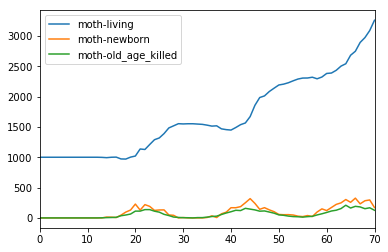

In [48]:
df[['moth-living', 'moth-newborn', 'moth-old_age_killed']].plot()
plt.show()

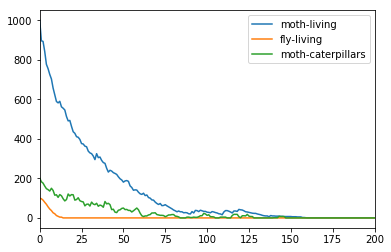

In [40]:
df[['moth-living', 'fly-living', 'moth-caterpillars', '']].plot()
plt.show()

<VideoWriter 0A9C08D0>

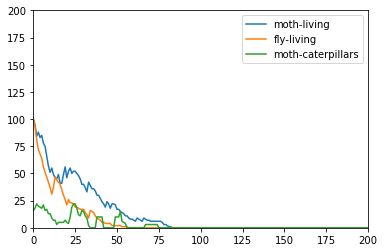

In [26]:
# video params
out_path = os.path.join('output_images', 'out_video')
fps = 5

my_plotter.make_video(out_path, fps=fps)

201

In [150]:
print(np.log10(11))

1.04139268516


In [159]:
w.instant

0

In [303]:
#for m in w.moths[0]:
#    print(m.age)
print(len(w.moths[0]))

200


In [13]:
# number of creatures
# lifespan
# initial lifespan distr
# gender distr
#

In [9]:
b = [0,0]

In [41]:
np.random.uniform() < 0.5

True

In [57]:
a = [(0,i) for i in range(5)]

In [62]:
a

[(0, 0), (0, 1), (0, 4)]

In [61]:
for idx,elem in enumerate(a):
    print(elem)
    if idx == 2:
        del a[idx]

(0, 0)
(0, 1)
(0, 3)


In [25]:
del a[0][2]

In [174]:
a = (0,2)

In [175]:
def foo(a, b):
    return a + b

In [176]:
foo(a[0], a[1])

2

In [178]:
foo(*a)

2

In [16]:
c = ['living_moths',
     'female_living_moths',
     'dead_moths',
     'randomly_killed_moths',
     'old_age_dead_moths', 
     'newborn_moths',
     'living_flies',
     'female_living_flies',
     'dead_flies',
     'randomly_killed_flies',
     'old_age_dead_flies',
     'actual_predator_flies',
     'newborn_flies'
     ]

In [17]:
c

['living_moths',
 'female_living_moths',
 'dead_moths',
 'randomly_killed_moths',
 'old_age_dead_moths',
 'newborn_moths',
 'living_flies',
 'female_living_flies',
 'dead_flies',
 'randomly_killed_flies',
 'old_age_dead_flies',
 'actual_predator_flies',
 'newborn_flies']

In [18]:
a = {xd: 0 for xd in c}

In [23]:
a = dict.fromkeys(c, 0)

In [3]:
a = ['sad', 'asd', 'asdad', 'asdas']
b = ['fly-', 'moth-']

In [6]:
elems = ['fly-'+ s for s in a] + ['moth-'+s for s in a]
elems

['fly-sad',
 'fly-asd',
 'fly-asdad',
 'fly-asdas',
 'moth-sad',
 'moth-asd',
 'moth-asdad',
 'moth-asdas']

In [35]:
data = dict.fromkeys(elems, 0)

In [33]:
df = pd.DataFrame(data=None, index=None, columns=elems)

In [52]:
df = df.append(pd.DataFrame(data=[data.values()], columns=elems))

In [53]:
df

,fly-sad,fly-asd,fly-asdad,fly-asdas,moth-sad,moth-asd,moth-asdad,moth-asdas
0,1,1,1,1,1,1,1,1
0,1,1,1,1,1,1,1,1
0,1,1,1,1,1,1,1,1
0,0,0,0,0,0,0,0,0


In [222]:
os.path.join(None, 'dsd')

TypeError: expected str, bytes or os.PathLike object, not NoneType

In [157]:
lst1 = [1, 2, 3]
lst2 = lst1
del lst1[:]
print(lst2)

[]


In [14]:
integrate.quad(lambda t: t**2, 0, 2)

(2.666666666666667, 2.960594732333751e-14)

In [44]:
f = np.array(df[['fly-living']].values.reshape(len(df)), dtype=int)

In [45]:
f

array([100, 100,  95,  98,  87,  75,  72,  69,  62,  56,  54,  46,  34,
        39,  31,  32,  30,  26,  17,  17,  14,  13,  13,  12,  25,  42,
        42,  38,  35,  32,  33,  29,  29,  26,  24,  24,  25,  21,  17,
        20,  18,  19,  19,  19,  17,  16,  15,   7,   6,   5,   5,  11,
        13,  13,   9,  11,  11,   9,   8,   9,   9,   9,   9,   9,   9,
         9,  15,  25,  22,  19,  22,  18,  18,  15,  13,  11,  11,  10,
         7,   7,   8,   6,   7,   7,   7,   5,   6,   2,   4,   1,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [46]:
lambda t: f[t]

<function __main__.<lambda>>

In [47]:
a = [1, 1,1,1,1,0,0,0,0,0]

In [50]:
z = integrate.simps(a)

In [51]:
z

4.5

In [106]:
tt = df.head()

In [107]:
tt

,moth-living,moth-dead,moth-male,moth-female,moth-randomly_killed,moth-old_age_killed,moth-parents,moth-newborn,moth-predation,fly-living,fly-dead,fly-male,fly-female,fly-randomly_killed,fly-old_age_killed,fly-parents,fly-newborn,fly-predation
0,100,0,51,49,0,0,0,0,0,100,0,53,47,0,0,0,0,0
1,88,6,48,46,6,0,0,0,0,100,0,53,47,0,0,0,0,0
2,82,7,47,41,3,3,0,0,0,95,9,51,53,5,4,1,13,1
3,74,8,42,39,4,3,0,0,0,98,9,52,55,5,4,1,12,1
4,59,10,37,32,5,5,0,0,0,87,10,47,50,7,3,0,0,0


In [108]:
tt = tt / 2

In [109]:
tt

,moth-living,moth-dead,moth-male,moth-female,moth-randomly_killed,moth-old_age_killed,moth-parents,moth-newborn,moth-predation,fly-living,fly-dead,fly-male,fly-female,fly-randomly_killed,fly-old_age_killed,fly-parents,fly-newborn,fly-predation
0,50,0,25.5,24.5,0,0,0,0,0,50,0,26.5,23.5,0,0,0,0,0
1,44,3,24,23,3,0,0,0,0,50,0,26.5,23.5,0,0,0,0,0
2,41,3.5,23.5,20.5,1.5,1.5,0,0,0,47.5,4.5,25.5,26.5,2.5,2,0.5,6.5,0.5
3,37,4,21,19.5,2,1.5,0,0,0,49,4.5,26,27.5,2.5,2,0.5,6,0.5
4,29.5,5,18.5,16,2.5,2.5,0,0,0,43.5,5,23.5,25,3.5,1.5,0,0,0


In [72]:
tt = tt + tt2

In [73]:
u.

,moth-living,moth-dead,moth-male,moth-female,moth-randomly_killed,moth-old_age_killed,moth-parents,moth-newborn,moth-predation,fly-living,fly-dead,fly-male,fly-female,fly-randomly_killed,fly-old_age_killed,fly-parents,fly-newborn,fly-predation
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
tt = pd.DataFrame(data=[[0] * len(u.df_columns)], index=range(200), columns=u.df_columns)

In [102]:
tt = pd.DataFrame(data=np.zeros([200, len(u.df_columns)], dtype=int), index=range(200), columns=u.df_columns)

In [123]:
tt = tt + tt

In [124]:
tt

,moth-living,moth-dead,moth-male,moth-female,moth-randomly_killed,moth-old_age_killed,moth-parents,moth-newborn,moth-predation,fly-living,fly-dead,fly-male,fly-female,fly-randomly_killed,fly-old_age_killed,fly-parents,fly-newborn,fly-predation
0,100,0,51,49,0,0,0,0,0,100,0,53,47,0,0,0,0,0
1,88,6,48,46,6,0,0,0,0,100,0,53,47,0,0,0,0,0
2,82,7,47,41,3,3,0,0,0,95,9,51,53,5,4,1,13,1
3,74,8,42,39,4,3,0,0,0,98,9,52,55,5,4,1,12,1
4,59,10,37,32,5,5,0,0,0,87,10,47,50,7,3,0,0,0


In [102]:
f = plt.figure()
ax = df[['moth-living']].plot()
f.add_axes()
plt.savefig('testx')
plt.close()